# Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from bs4 import BeautifulSoup

import warnings
warnings.filterwarnings('ignore')
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import gensim
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Importing dataset

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/nlp/train.csv')
df.sample(10)


,id,qid1,qid2,question1,question2,is_duplicate
194481,194481,65786,81400,How shall I prepare for IBPS PO interview?,How should one prepare for IBPS PO interview?,1
221515,221515,172745,328873,What have we gained from demonetization?,What are the positive impacts of Demonetization?,1
89910,89910,150981,150982,After morning walk what should we have to eat?,What should I eat in the morning?,0
10518,10518,20367,20368,What is the best definition of 'transdisciplin...,What is the best definition of science?,0
3339,3339,6619,6620,How much weight would I lose in a month if I e...,How much weight can I lose running 1 mile per ...,0
265285,265285,219118,193798,Will Batman v Superman: Dawn of Justice flop?,Is Batman v Superman: Dawn of Justice good?,1
12207,12207,23533,23534,What is critical radius of insulation?,What is the motive of critical radius of insul...,0
41615,41615,75118,75119,What was McCarthyism?,What is McCarthyism?,1
281847,281847,221958,401668,Where does lactic acid formation occur during ...,How is lactic acid fermentation similar to aer...,0
386103,386103,227690,41505,How do you move on after a break up?,Dating and Relationships: How can I get over a...,1


# Basic Eda

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


## Checking Duplicates

In [ ]:
df.duplicated().sum()

0

no duplicated raws

## Distribution of duplicated and non duplicated question

<Axes: xlabel='is_duplicate'>

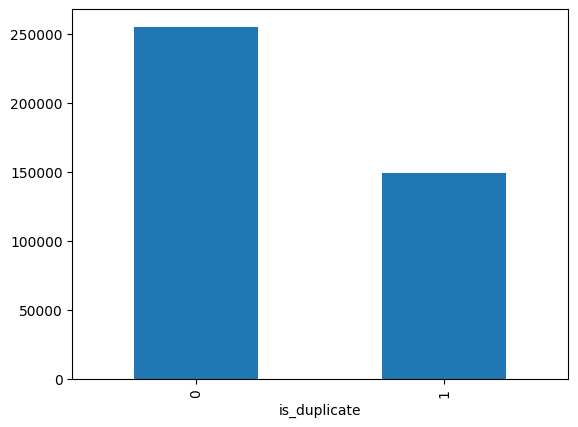

In [ ]:
df['is_duplicate'].value_counts().plot(kind='bar')

## Repeated Question

In [ ]:
qid=pd.Series(df['qid1'].tolist()+df['qid2'].tolist())
print(f'number of unique questions is {qid.nunique()}')
rep=qid.value_counts()>1
print(f'number of repeated questions is {rep[rep].sum()}')

number of unique questions is 537933
number of repeated questions is 111780


## Histogram for repeated questions

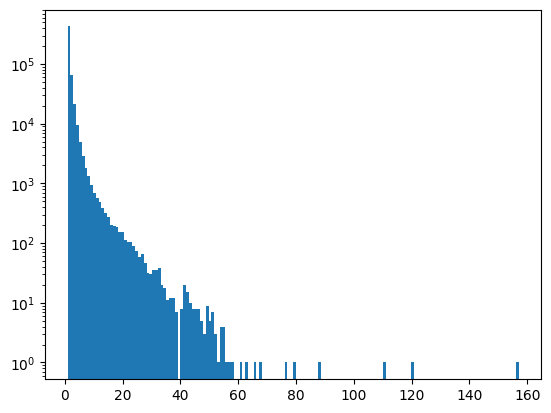

In [ ]:
plt.hist(qid.value_counts().values,bins=160)
plt.yscale('log')
plt.show()

# Under Sampling the dataset

In [ ]:
df1=df[df['is_duplicate']==1]
df0=df[df['is_duplicate']==0]
df0=df0.sample(n=df1.shape[0],random_state=42)
df=pd.concat([df1,df0])

In [ ]:
df.shape

(298526, 6)

In [ ]:
df=df.sample(30000)

# Preprocessing

In [ ]:
def preprocess(q):

    q = str(q).lower().strip()

    # Replace certain special characters with their string equivalents
    q = q.replace('%', ' percent')
    q = q.replace('$', ' dollar ')
    q = q.replace('₹', ' rupee ')
    q = q.replace('€', ' euro ')
    q = q.replace('@', ' at ')

    # The pattern '[math]' appears around 900 times in the whole dataset.
    q = q.replace('[math]', '')

    # Replacing some numbers with string equivalents (not perfect, can be done better to account for more cases)
    q = q.replace(',000,000,000 ', 'b ')
    q = q.replace(',000,000 ', 'm ')
    q = q.replace(',000 ', 'k ')
    q = re.sub(r'([0-9]+)000000000', r'\1b', q)
    q = re.sub(r'([0-9]+)000000', r'\1m', q)
    q = re.sub(r'([0-9]+)000', r'\1k', q)

    # Decontracting words
    # https://en.wikipedia.org/wiki/Wikipedia%3aList_of_English_contractions
    # https://stackoverflow.com/a/19794953
    contractions = {
    "ain't": "am not",
    "aren't": "are not",
    "can't": "can not",
    "can't've": "can not have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
    }

    q_decontracted = []

    for word in q.split():
        if word in contractions:
            word = contractions[word]

        q_decontracted.append(word)

    q = ' '.join(q_decontracted)
    q = q.replace("'ve", " have")
    q = q.replace("n't", " not")
    q = q.replace("'re", " are")
    q = q.replace("'ll", " will")

    # Removing HTML tags
    q = BeautifulSoup(q)
    q = q.get_text()

    # Remove punctuations
    pattern = re.compile('\W')
    q = re.sub(pattern, ' ', q).strip()


    return q


In [ ]:
preprocess("hi i ! wasn't there <p>done</p>?")

'hi i   was not there done'

In [ ]:
df['question1']=df['question1'].apply(preprocess)
df['question2']=df['question2'].apply(preprocess)

# Extracting New features

## length of questions

In [ ]:
df["q1_len"]=df['question1'].str.len()
df["q2_len"]=df['question2'].str.len()

## number of words

In [ ]:
df['num_words1']=df['question1'].apply(lambda x:len(str(x).split()))
df['num_words2']=df['question2'].apply(lambda x:len(str(x).split()))

## Number of common words

In [ ]:
def common_words(df):
  q1=set(map(lambda x:x.lower().strip(),df['question1'].split(' ')))
  q2=set(map(lambda x:x.lower().strip(),df['question2'].split(' ')))
  return len(q1.intersection(q2))

In [ ]:
df['no_common_words']=df.apply(common_words,axis=1)

## Total words

In [ ]:
def total_words(df):
  q1=set(map(lambda x:x.lower().strip(),df['question1'].split(' ')))
  q2=set(map(lambda x:x.lower().strip(),df['question2'].split(' ')))
  return len(q1.union(q2))

In [ ]:
df['total_words']=df.apply(total_words,axis=1)

## Percentage of word sharing

In [ ]:
df['word_share']=round(df['no_common_words']/df['total_words'],2)

## Advanced Features

In [ ]:
# Advanced Features


def fetch_token_features(row):

    q1 = row['question1']
    q2 = row['question2']

    SAFE_DIV = 0.0001

    STOP_WORDS = stopwords.words("english")

    token_features = [0.0]*8

    # Converting the Sentence into Tokens:
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features

    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])

    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])

    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))

    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))

    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))


    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)

    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])

    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])

    return token_features


In [ ]:
token_features =df.apply(fetch_token_features, axis=1)

df["cwc_min"]       = list(map(lambda x: x[0], token_features))
df["cwc_max"]       = list(map(lambda x: x[1], token_features))
df["csc_min"]       = list(map(lambda x: x[2], token_features))
df["csc_max"]       = list(map(lambda x: x[3], token_features))
df["ctc_min"]       = list(map(lambda x: x[4], token_features))
df["ctc_max"]       = list(map(lambda x: x[5], token_features))
df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
df["first_word_eq"] = list(map(lambda x: x[7], token_features))

## Extracing some length feature

In [ ]:
!pip install distance

In [ ]:
import distance

def fetch_length_features(row):

    q1 = row['question1']
    q2 = row['question2']

    length_features = [0.0]*3

    # Converting the Sentence into Tokens:
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return length_features

    # Absolute length features
    length_features[0] = abs(len(q1_tokens) - len(q2_tokens))

    #Average Token Length of both Questions
    length_features[1] = (len(q1_tokens) + len(q2_tokens))/2

    strs = list(distance.lcsubstrings(q1, q2))
    length_features[2] = len(strs[0]) / (min(len(q1), len(q2)) + 1)

    return length_features


In [ ]:
length_features = df.apply(fetch_length_features, axis=1)

df['abs_len_diff'] = list(map(lambda x: x[0], length_features))
df['mean_len'] = list(map(lambda x: x[1], length_features))
df['longest_substr_ratio'] = list(map(lambda x: x[2], length_features))

## Fuzzy Features

In [ ]:
!pip install fuzzywuzzy

In [ ]:
# Fuzzy Features
from fuzzywuzzy import fuzz

def fetch_fuzzy_features(row):

    q1 = row['question1']
    q2 = row['question2']

    fuzzy_features = [0.0]*4

    # fuzz_ratio
    fuzzy_features[0] = fuzz.QRatio(q1, q2)

    # fuzz_partial_ratio
    fuzzy_features[1] = fuzz.partial_ratio(q1, q2)

    # token_sort_ratio
    fuzzy_features[2] = fuzz.token_sort_ratio(q1, q2)

    # token_set_ratio
    fuzzy_features[3] = fuzz.token_set_ratio(q1, q2)

    return fuzzy_features

In [ ]:
fuzzy_features = df.apply(fetch_fuzzy_features, axis=1)

# Creating new feature columns for fuzzy features
df['fuzz_ratio'] = list(map(lambda x: x[0], fuzzy_features))
df['fuzz_partial_ratio'] = list(map(lambda x: x[1], fuzzy_features))
df['token_sort_ratio'] = list(map(lambda x: x[2], fuzzy_features))
df['token_set_ratio'] = list(map(lambda x: x[3], fuzzy_features))

# Eda with new feature

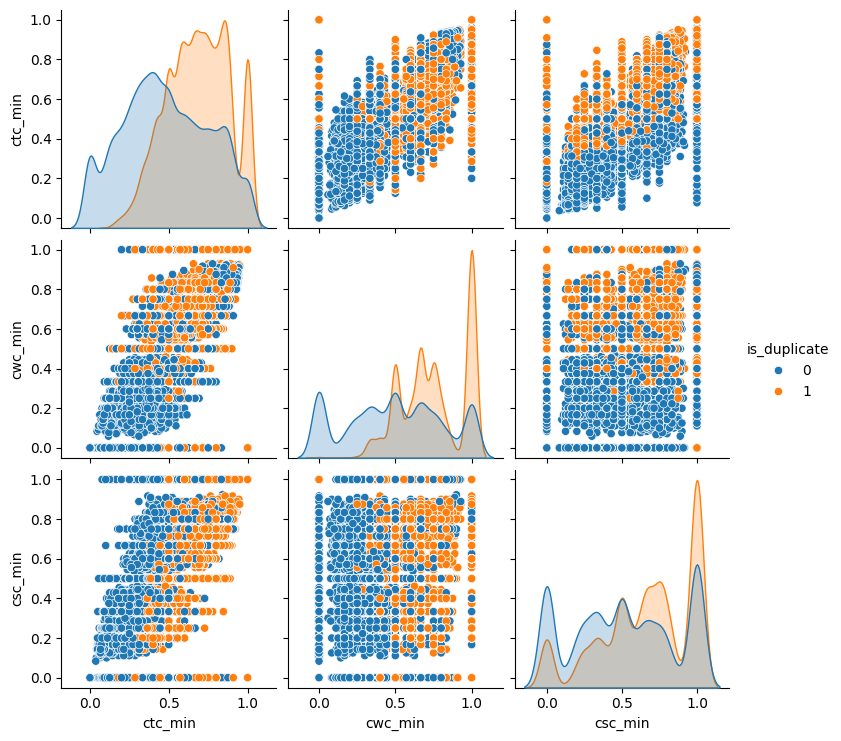

In [ ]:
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'is_duplicate']],hue='is_duplicate')

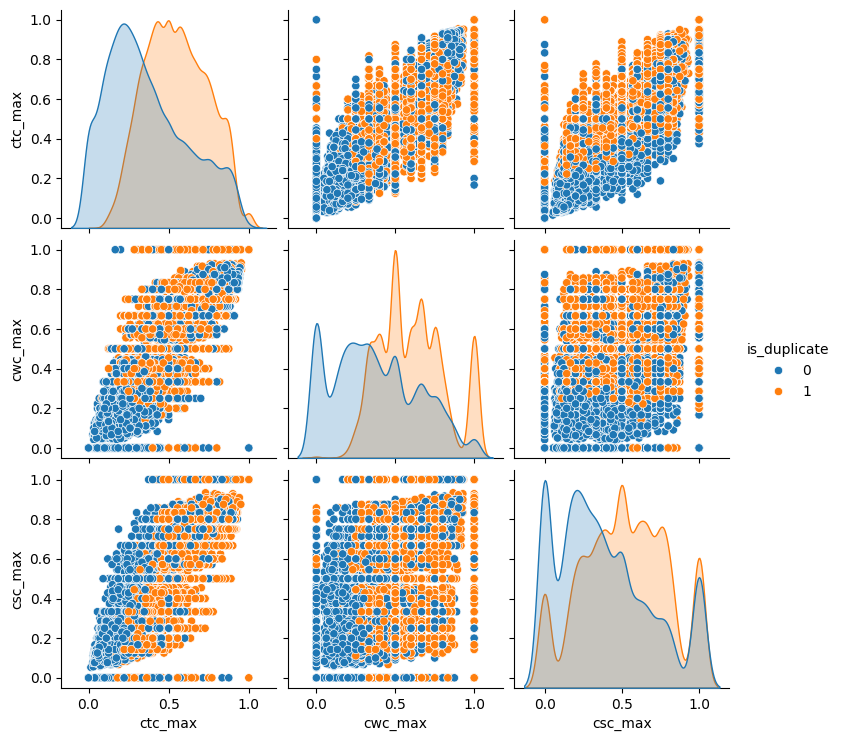

In [ ]:
sns.pairplot(df[['ctc_max', 'cwc_max', 'csc_max', 'is_duplicate']],hue='is_duplicate')

as common words and commun tokens increases chances of being dupicate questions are increasing

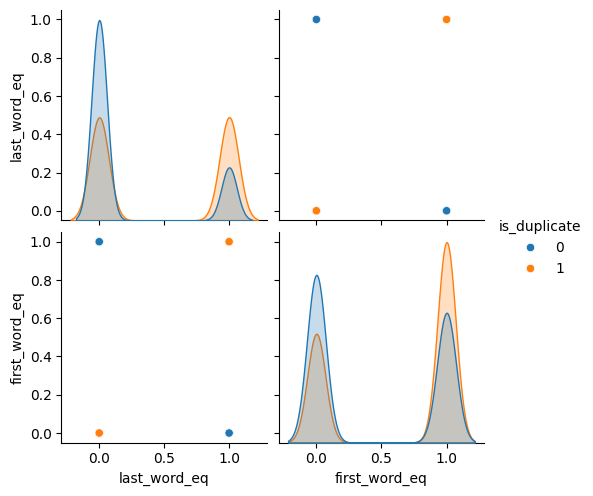

In [ ]:
sns.pairplot(df[['last_word_eq', 'first_word_eq', 'is_duplicate']],hue='is_duplicate')

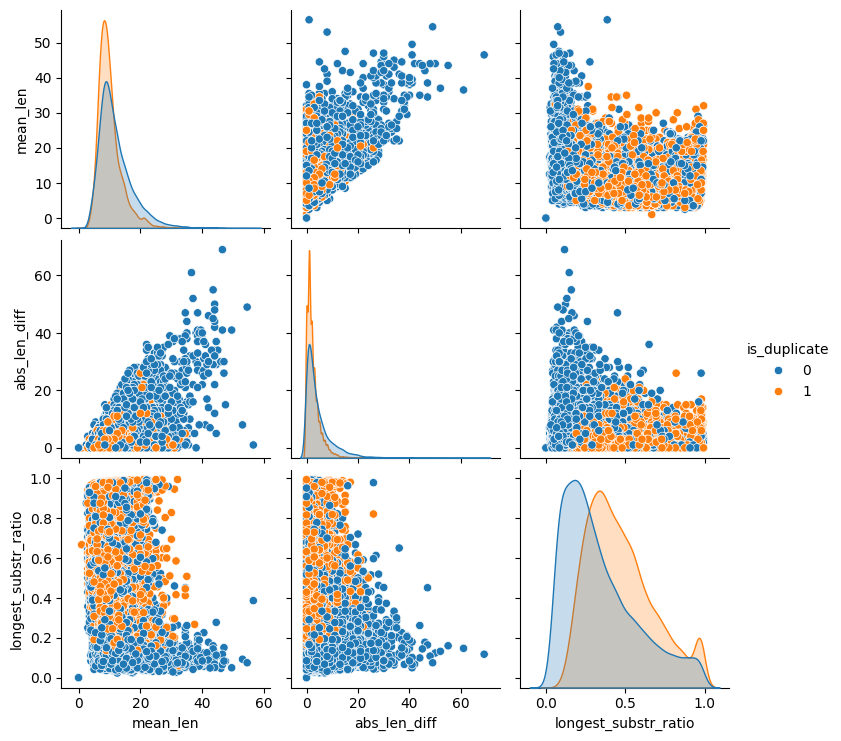

In [ ]:
sns.pairplot(df[['mean_len', 'abs_len_diff','longest_substr_ratio', 'is_duplicate']],hue='is_duplicate')

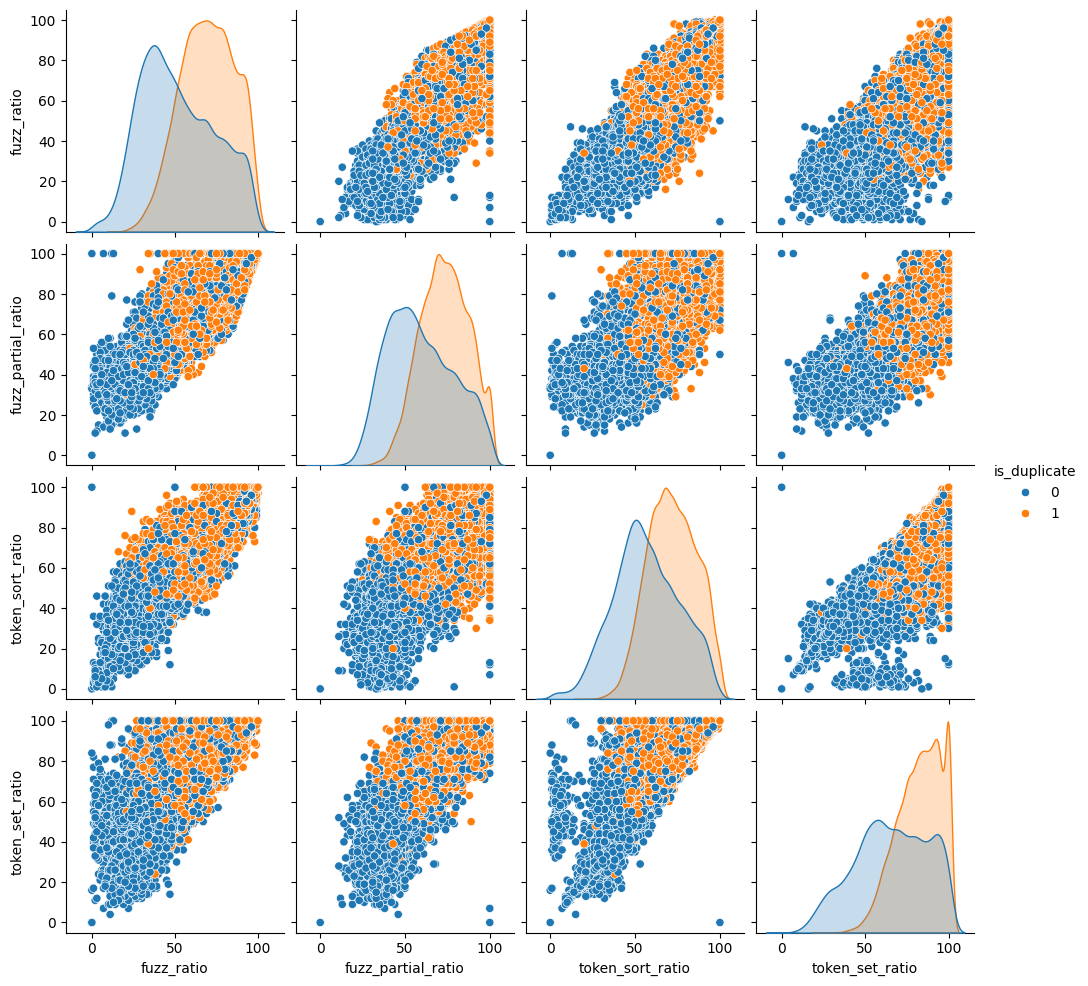

In [ ]:
sns.pairplot(df[['fuzz_ratio', 'fuzz_partial_ratio','token_sort_ratio','token_set_ratio', 'is_duplicate']],hue='is_duplicate')

In [ ]:
df.shape

(30000, 28)

# Vectorization

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
questions = list(df['question1']) + list(df['question2'])

cv = CountVectorizer(max_features=3000)
q1_arr, q2_arr = np.vsplit(cv.fit_transform(questions).toarray(),2)

In [ ]:
temp_df1 = pd.DataFrame(q1_arr, index= df.index,columns=range(3000))
temp_df2 = pd.DataFrame(q2_arr, index= df.index,columns=range(3000,6000))
temp_df = pd.concat([temp_df1, temp_df2], axis=1)
temp_df.shape

(30000, 6000)

In [ ]:
final_df = pd.concat([df, temp_df], axis=1)
print(final_df.shape)
final_df.head()

(30000, 6028)


,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,num_words1,num_words2,...,5990,5991,5992,5993,5994,5995,5996,5997,5998,5999
174809,174809,11105,269306,do you know about the greatest adornments desi...,what are the most beautifully designed websites,0,110,47,18,7,...,0,0,0,0,0,0,0,0,0,0
198772,198772,300077,199187,can we see downvotes on quora if no what is t...,will you be able to see the people who downvot...,1,123,69,27,14,...,0,0,1,0,1,0,0,0,0,0
271652,271652,389781,389782,why are brahmins not minority in india,who are the bihari people,0,38,25,7,5,...,0,0,0,0,0,0,0,0,0,0
1365,1365,2721,2722,is bashar al assad a psychopath,where does bashar al assad live,0,31,31,6,6,...,0,0,0,0,0,0,0,0,0,0
341629,341629,469496,469497,what is the list of india tech news websites,india tech news websites,1,44,24,9,4,...,0,0,0,0,0,0,0,0,0,0


# Train test split

In [ ]:
final_df=final_df.drop(['id','qid1','qid2','question1','question2'],axis=1)

In [ ]:
final_df.columns = final_df.columns.astype(str)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(final_df.drop('is_duplicate',axis=1), final_df['is_duplicate'], test_size=0.33, random_state=42)
X,X_val,y,y_val=train_test_split(X_train,y_train,test_size=0.1,random_state=42)

In [ ]:
X_train.shape

(20100, 6022)

# Model Training and Evaluation

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
param_grid = {
    'max_features': ['auto', 'log2',],
    'max_depth': [4, 5, 6, 7, 8],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']

}
grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, verbose=1)
grid.fit(X_val, y_val)
print(grid.best_params_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
{'bootstrap': True, 'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto'}


In [ ]:
rf=RandomForestClassifier(bootstrap=True,criterion='gini', max_depth=8, max_features='log2')

In [ ]:
rf.fit(X,y)

RandomForestClassifier(max_depth=8, max_features='log2')

In [ ]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,roc_curve,auc
y_pred = rf.predict(X_test)
y_pred_proba = rf.predict_proba(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:, 1])
roc_auc = auc(fpr, tpr)

print("Accuracy score", accuracy_score(y_test,y_pred))
print("\n")
print(classification_report(y_test,y_pred))
print("\n")
print(confusion_matrix(y_test,y_pred))
print("\n")
print("Area under the ROC curve:", roc_auc)


Accuracy score 0.7252525252525253


              precision    recall  f1-score   support

           0       0.78      0.62      0.69      4907
           1       0.69      0.82      0.75      4993

    accuracy                           0.73      9900
   macro avg       0.73      0.72      0.72      9900
weighted avg       0.73      0.73      0.72      9900



[[3066 1841]
 [ 879 4114]]


Area under the ROC curve: 0.8000216606489353


In [ ]:
from xgboost import XGBClassifier

xgb = XGBClassifier()
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)
y_pred_proba = xgb.predict_proba(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:, 1])
roc_auc = auc(fpr, tpr)

print("Accuracy score", accuracy_score(y_test,y_pred))
print("\n")
print(classification_report(y_test,y_pred))
print("\n")
print(confusion_matrix(y_test,y_pred))
print("\n")
print("Area under the ROC curve:", roc_auc)

Accuracy score 0.7934343434343434


              precision    recall  f1-score   support

           0       0.85      0.71      0.77      4907
           1       0.76      0.87      0.81      4993

    accuracy                           0.79      9900
   macro avg       0.80      0.79      0.79      9900
weighted avg       0.80      0.79      0.79      9900



[[3504 1403]
 [ 642 4351]]


Area under the ROC curve: 0.8773349532630786


In [ ]:
X_train

,q1_len,q2_len,num_words1,num_words2,no_common_words,total_words,word_share,cwc_min,cwc_max,csc_min,...,5990,5991,5992,5993,5994,5995,5996,5997,5998,5999
385862,53,63,11,12,3,19,0.16,0.199996,0.166664,0.399992,...,0,0,0,0,0,0,0,0,0,0
118046,68,72,15,15,6,25,0.24,0.666656,0.444440,0.333328,...,0,0,0,0,0,0,0,0,0,0
343718,54,51,10,9,7,13,0.54,0.749981,0.599988,0.799984,...,0,0,0,0,0,0,0,0,0,0
87944,68,109,14,22,10,22,0.45,0.714276,0.499995,0.833319,...,0,0,1,0,0,0,0,0,0,0
241765,62,98,14,20,7,27,0.26,0.666656,0.444440,0.428565,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24275,29,40,6,7,5,8,0.62,0.749981,0.749981,0.999950,...,0,0,0,0,0,0,0,0,0,0
8177,79,69,14,13,12,15,0.80,0.857131,0.749991,0.999983,...,0,0,0,0,0,0,0,0,0,0
25969,47,45,9,9,9,11,0.82,0.749981,0.749981,0.999980,...,0,0,0,0,0,0,0,0,0,0
229822,79,147,17,28,6,29,0.21,0.399992,0.222220,0.333330,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
import joblib

joblib.dump(xgb, "model.joblib")
joblib.dump(cv, "cv.joblib")


['cv.joblib']